In [1]:
# Add the genderComputer library to the path
import os
import sys

path = os.path.join(os.getcwd(), 'vendor', 'genderComputer')
sys.path.insert(0, path)

In [2]:
# Infer the gender of the authors
import analyze_genders

df = analyze_genders.dataframe()
aggregates = analyze_genders.aggregate_authorship(df)

df.head(10)

,paper_id,conf,year,author_position,author_name,male,female,unisex,unknown,author_id,author_position_last,year_first_paper
15348,1135503,edbt,2017,0,Rohit Kumar,True,False,False,False,19/139-2,1,2017
15349,1135503,edbt,2017,1,Toon Calders,True,False,False,False,c/ToonCalders,1,2008
15350,1135504,edbt,2017,0,Zahid Abul-Basher,True,False,False,False,117/7521,4,2017
15351,1135504,edbt,2017,1,Nikolay Yakovets,True,False,False,False,92/9686,4,2015
15352,1135504,edbt,2017,2,Parke Godfrey,False,False,False,True,g/ParkeGodfrey,4,2001
15353,1135504,edbt,2017,3,Shadi Ghajar-Khosravi,True,False,False,False,132/4916,4,2017
15354,1135504,edbt,2017,4,Mark H. Chignell,True,False,False,False,08/2050,4,2017
15355,1135505,edbt,2017,0,Manoj K. Agarwal,True,False,False,False,90/1415,1,2009
15356,1135505,edbt,2017,1,Krithi Ramamritham,False,True,False,False,r/KrithiRamamritham,1,1987
15357,1135506,edbt,2017,0,Sandeep Akinapelli,False,False,True,False,117/2607,2,2017


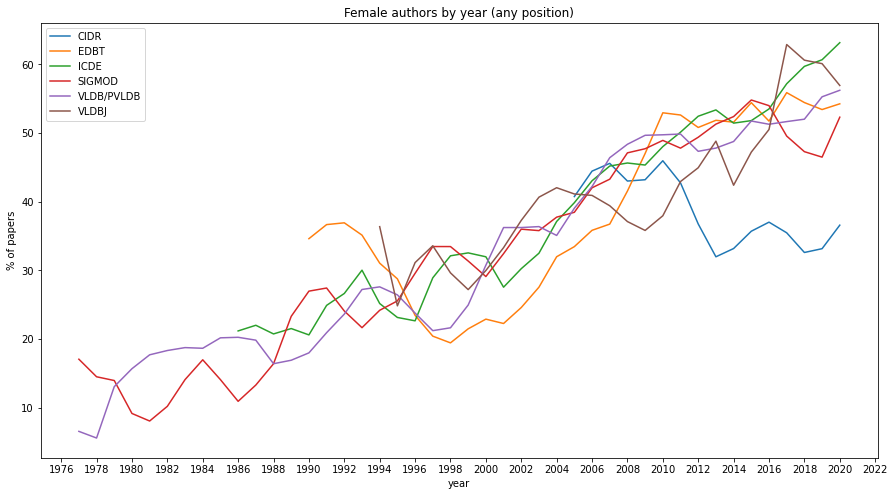

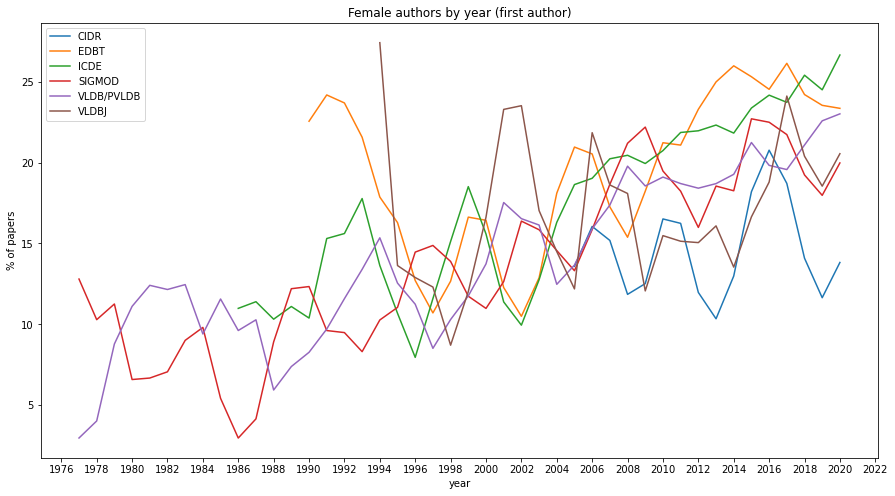

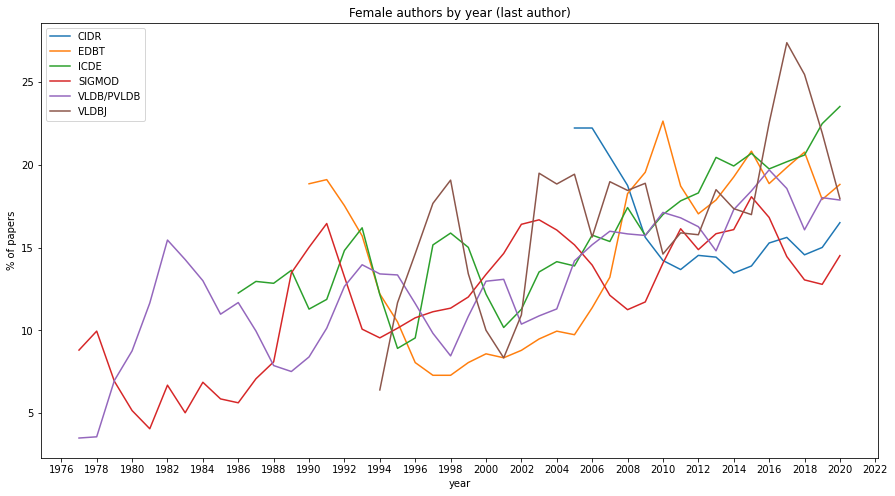

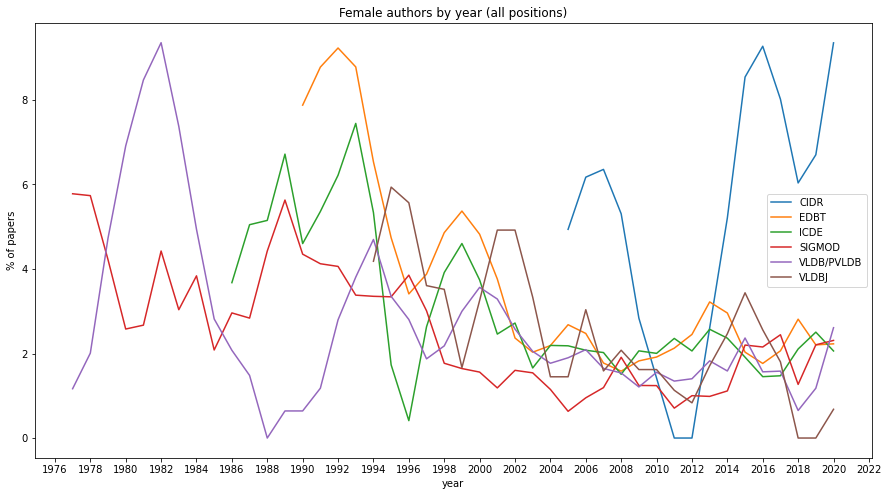

In [3]:
analyze_genders.plot_authors(aggregates['any'], 'any position')
analyze_genders.plot_authors(aggregates['first'], 'first author')
analyze_genders.plot_authors(aggregates['last'], 'last author')
analyze_genders.plot_authors(aggregates['all'], 'all positions')